# Project 3-1: Inversion and sampling using diffusion models (55 pt)

In this project, given a real image (denoted as $x_0$) as input, we will invert this image into the diffusion model to get the initial noise (denoted as $x_T$). Then starting the diffusion sampling steps from this $x_T$, we can get a reconstruction $\widetilde{x}_0$ of $x_0$. We will use DDIM (Denoising Diffusion Implicit Models)[1] as the diffusion sampling method. To perform inversion, we will perform DDIM sampling in reverse order. 

## Task 0: Before you start

Before you start, you need to understand: <br>
1. The definition of forward and backward process in diffusion models. You can check the tutorial in [2]. You should also get familiar with the notations and symbols. However, you are not required to derive the formulas; <br>
2. The definition of inversion using diffusion models; <br>
3. Stable Diffusion [3] and its architecture [4], as we will use Stable Diffusion as our backbone model; <br>
4. The diffusers library [5]. Please check the "Get started" section in the link [4] to install diffusers library. Please also go through "Tutorial" section to learn its basic usage.

[1] Song, Jiaming, Chenlin Meng, and Stefano Ermon. "Denoising diffusion implicit models." arXiv preprint arXiv:2010.02502 (2020). <br>
[2] https://lilianweng.github.io/posts/2021-07-11-diffusion-models/ <br>
[3] https://github.com/Stability-AI/stablediffusion <br>
[4] Rombach, Robin, et al. "High-resolution image synthesis with latent diffusion models." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2022. <br>
[5] https://huggingface.co/docs/diffusers/index

## Task 1: Get Started (2.5 pt)

Please make sure you install pytorch>=1.7, numpy, PIL, transformers and diffusers. <br>
Possible library versions: <br>
pytorch==1.12.1 <br>
transformers==4.28.1 <br>
diffusers==0.16.1

In [1]:
import torch
import numpy as np
from PIL import Image
from diffusers import DDIMScheduler
from diffusers import StableDiffusionPipeline

# Supress some unnecessary warnings when loading the CLIPTextModel
from transformers import logging
logging.set_verbosity_error()

# Set device
torch_device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(torch_device)

C:\Users\WANGH0M\AppData\Local\anaconda3\envs\DLVC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:1


In [2]:
# Load the scheduler and model pipeline from diffusers library
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                     set_alpha_to_one=False)
sdm_model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", scheduler=scheduler).to(torch_device)


vae\diffusion_pytorch_model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
C:\Users\WANGH0M\AppData\Local\anaconda3\envs\DLVC\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:128: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.21.4",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value

## Task 2: Implement DDIM method (30 pt)

Here we implement both DDIM inversion and sampling in a class called `DDIMMethod`. In the generation stage, we continuously apply formula (12) in DDIM paper [1], starting from $x_T$ and ending at $x_0$. For inversion, we apply the same formula but we start from $x_0$ and end at $x_T$. <br>
Please follow the instructions below and fill out the missing lines.

In [142]:
def load_image(image_path, height=512, width=512):
    image = Image.open(image_path).convert('RGB').resize((height, width))
    image = np.array(image)
    return image

##Hui refer: https://github.com/eric-ai-lab/photoswap/blob/main/inversion.py
##Hui refer: https://github.com/google/prompt-to-prompt/blob/main/null_text_w_ptp.ipynb

class DDIMMethod(): 
    def __init__(self, model, num_ddim_steps=50):
        self.model = model
        self.num_ddim_steps = num_ddim_steps
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(self.num_ddim_steps)
        self.total_steps = len(self.model.scheduler.timesteps)  # Total number of sampling steps.
        print('Total number of steps: ', self.total_steps)
        self.prompt = None
        self.context = None
    
    # Please implement formula (12) in the DDIM paper. 
    # We set sigma_t = 0 so some terms can be ignored.
    def next_step(self, noise_pred: torch.FloatTensor, timestep: int, latent: torch.FloatTensor, mode='inversion'):
        # alpha_prod_t, alpha_prod_t_next and beta_prod_t are already calculated for you.
        # Use these variables for the TODO tasks.
        if mode == 'inversion':
            timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
            alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
            alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
            #print(timestep, next_timestep) ##should be timestep > next_timestep

        elif mode == 'sampling':
            prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
            alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
            alpha_prod_t_next = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
            #print(timestep, prev_timestep) ##should be timestep < next_timestep
            
        beta_prod_t = 1 - alpha_prod_t
        #beta_prod_t_next = 1 - alpha_prod_t_next
        
        #sigma_t = ((beta_prod_t/beta_prod_t_next)*(1-alpha_prod_t_next/alpha_prod_t)) ** (0.5) ##Hui: for DDPM
        sigma_t = 0 ##Hui: set sigma_t = 0 for DDIM
        ##Hui: both noise_pred and initial latent are torch.Size([1, 4, 64, 64])

        ##Hui note: x_t-1 ~ alpha_t_1 : next; x_t, alpha_t: current
        next_original_sample = (latent - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5) # TODO: 
        next_sample_direction = (1 - alpha_prod_t_next - sigma_t**2) ** (0.5) * noise_pred # TODO:
        next_sample = alpha_prod_t_next ** (0.5) * next_original_sample + next_sample_direction # TODO:
        return next_sample
    

    # Decode the latent to image using the VAE.
    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach() ##Hui: scales the input latent vector by a factor, which is used to normalize the latent vector to a standard normal distribution
        image = self.model.vae.decode(latents)['sample'] ##Hui: obtains reconstructed image. a tensor with values between -1 and 1
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1) ##Hui: scales the image values from (-1,1) to (0,1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8) ##Hui: the numpy array is scaled to the range (0, 255)
        return image

    # Encode the image to latent using the VAE.
    @torch.no_grad()
    def image2latent(self, image): ##Hui: image[h, w, channel]==[512,512,3]
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:##Hui: input image is a numpy array, it is first normalized to the range (-1,1)
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(self.model.device) ##Hui: and converted to a tensor with the correct dimensions.
                latents = self.model.vae.encode(image)['latent_dist'].mean ##Hui: passes the input tensor through the VAE encoder and obtains the latent vector
                latents = latents * 0.18215
        return latents ##Hui: latents[channel, h, w]==torch.Size([1, 4, 64, 64])

    # Prepare the conditional embeddings
    # Uncond_embeddings are the embeddings of the empty string,
    # while the cond_embeddings are the embeddings of the input prompt.
    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0] ##Hui: conditional embeddings
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    # Please implement the DDIM Loop by continuously applying formula (12). 
    # We will perform this steps for `self.total_steps` times.
    # Note that the timesteps saved in `self.model.scheduler.timesteps` are from $T$ to $1$, not $1$ to $T$.
    @torch.no_grad()
    def ddim_loop(self, latent, mode='inversion'):
        _, cond_embeddings = self.context.chunk(2) # We only use conditional embeddings here. Hui:i.e. text_embeddings
        #print(cond_embeddings.shape) ##Hui[1,77,768]
        all_latents = [latent]  # We append $x_0$ to the start of the latent list.
        latent = latent.clone().detach()
        for i in range(self.total_steps):
            if mode == 'inversion':
                t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps)-i-1] # TODO: fill in the correct index.
                #print(t) ##Hui:1,21,41,...,981
            elif mode == 'sampling':
                t = self.model.scheduler.timesteps[i]  # TODO: fill in the correct index.
                #print(t) ##Hui: 981,961,...1
            noise_pred = self.model.unet(latent, t, encoder_hidden_states=cond_embeddings)["sample"] # TODO: refer to the diffusers to see the usage of self.model.unet. 
                          # Here we only use cond_embeddings as the encoder_hidden_states.
            latent = self.next_step(noise_pred, t, latent, mode)  # TODO: use self.next_step to get the next latent.
            all_latents.append(latent)
        return all_latents

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def invert(self, image_path: str, prompt: str):
        self.init_prompt(prompt)
        image_gt = load_image(image_path)
        #print(image_gt.shape) ##Hui: (512, 512, 3)
        latent = self.image2latent(image_gt)
        #print(latent.shape) ##Hui: torch.Size([1, 4, 64, 64])
        ddim_latents = self.ddim_loop(latent, mode='inversion')

        return ddim_latents
    
    @torch.no_grad()
    def sample(self, latent: torch.Tensor, prompt: str):
        self.init_prompt(prompt)
        ddim_latents = self.ddim_loop(latent, mode='sampling')
        
        return ddim_latents


## Task 3: Invert an image (5 pt)

In [145]:
ddim_method = DDIMMethod(sdm_model)

Total number of steps:  50


In [146]:
# Real image inversion
image_path = "./inversion_imgs/cat_dog.jpg"
inversion_prompt = "Photo of a cat and a dog"  # prompt can be empty or a description of the image.
mode = "inversion"
ddim_latents = ddim_method.invert(image_path, inversion_prompt)

tensor(-19) tensor(1)
tensor(1) tensor(21)
tensor(21) tensor(41)
tensor(41) tensor(61)
tensor(61) tensor(81)
tensor(81) tensor(101)
tensor(101) tensor(121)
tensor(121) tensor(141)
tensor(141) tensor(161)
tensor(161) tensor(181)
tensor(181) tensor(201)
tensor(201) tensor(221)
tensor(221) tensor(241)
tensor(241) tensor(261)
tensor(261) tensor(281)
tensor(281) tensor(301)
tensor(301) tensor(321)
tensor(321) tensor(341)
tensor(341) tensor(361)
tensor(361) tensor(381)
tensor(381) tensor(401)
tensor(401) tensor(421)
tensor(421) tensor(441)
tensor(441) tensor(461)
tensor(461) tensor(481)
tensor(481) tensor(501)
tensor(501) tensor(521)
tensor(521) tensor(541)
tensor(541) tensor(561)
tensor(561) tensor(581)
tensor(581) tensor(601)
tensor(601) tensor(621)
tensor(621) tensor(641)
tensor(641) tensor(661)
tensor(661) tensor(681)
tensor(681) tensor(701)
tensor(701) tensor(721)
tensor(721) tensor(741)
tensor(741) tensor(761)
tensor(761) tensor(781)
tensor(781) tensor(801)
tensor(801) tensor(821)
tens

In [118]:
# Visualize 
# Please append x_0, x_10, x_20, x_30, x_40, x_50 to the image_inversion_list. Please use this order.
image_inversion_list = []
for i in range(0, 51, 10):
    image_inversion = ddim_method.latent2image(ddim_latents[i])  # TODO: fill in the correct latent from ddim_latents.
    image_inversion = Image.fromarray(image_inversion)
    image_inversion_list.append(image_inversion)

In [119]:
# visualize a list of pil images
def visualize(image_list):
    width, height = image_list[0].size
    new_im = Image.new('RGB', (width * len(image_list), height))
    for i, image in enumerate(image_list):
        new_im.paste(image, (i * width, 0))
    return new_im

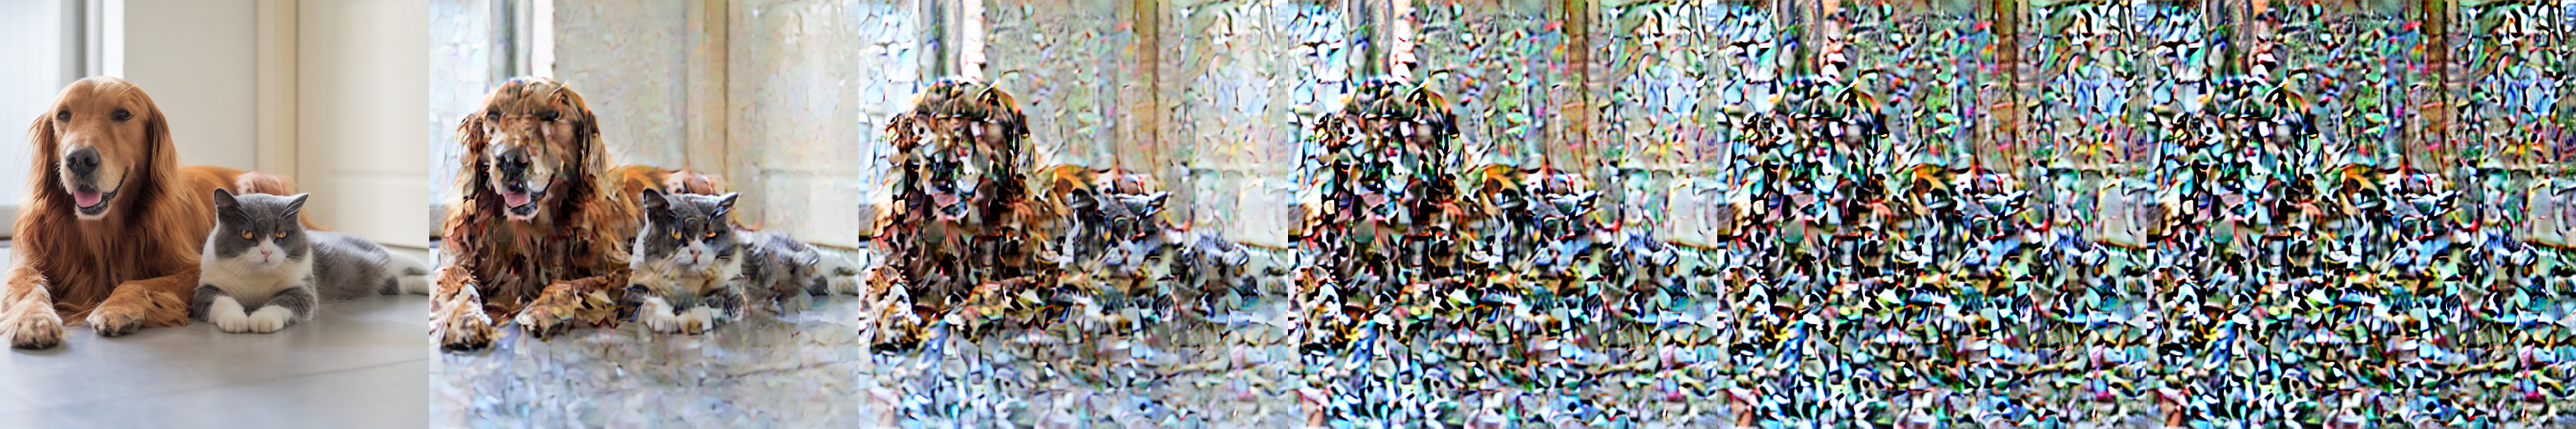

In [120]:
# The images from left to right should be x_0, x_10, x_20, x_30, x_40, x_50.
visualize(image_inversion_list)

## Task 4: Test the inverted latent (7.5 pt)

We need to know that if the inverted $x_T$ we obtain is good or not. Therefore, we need to perform diffusion sampling steps to go from $x_T$ to the reconstructed $\widetilde{x}_0$, and compare $\widetilde{x}_0$ with $x_0$.

In [147]:
# We test if our reconstructed image is close to the original image.
input_latent = ddim_latents[50] # TODO: fill in the correct index.
prompt = inversion_prompt # We have to use the same prompt as the one used in the inversion in order to reconstruct the image.
ddim_latents = ddim_method.sample(input_latent, prompt)

tensor(981) tensor(961)
tensor(961) tensor(941)
tensor(941) tensor(921)
tensor(921) tensor(901)
tensor(901) tensor(881)
tensor(881) tensor(861)
tensor(861) tensor(841)
tensor(841) tensor(821)
tensor(821) tensor(801)
tensor(801) tensor(781)
tensor(781) tensor(761)
tensor(761) tensor(741)
tensor(741) tensor(721)
tensor(721) tensor(701)
tensor(701) tensor(681)
tensor(681) tensor(661)
tensor(661) tensor(641)
tensor(641) tensor(621)
tensor(621) tensor(601)
tensor(601) tensor(581)
tensor(581) tensor(561)
tensor(561) tensor(541)
tensor(541) tensor(521)
tensor(521) tensor(501)
tensor(501) tensor(481)
tensor(481) tensor(461)
tensor(461) tensor(441)
tensor(441) tensor(421)
tensor(421) tensor(401)
tensor(401) tensor(381)
tensor(381) tensor(361)
tensor(361) tensor(341)
tensor(341) tensor(321)
tensor(321) tensor(301)
tensor(301) tensor(281)
tensor(281) tensor(261)
tensor(261) tensor(241)
tensor(241) tensor(221)
tensor(221) tensor(201)
tensor(201) tensor(181)
tensor(181) tensor(161)
tensor(161) tens

In [148]:
image_sampling_list = []
for i in range(0, 51, 10):
    image_sampling = ddim_method.latent2image(ddim_latents[50-i])  # TODO: fill in the correct latent from ddim_latents.
    image_sampling = Image.fromarray(image_sampling)
    image_sampling_list.append(image_sampling)

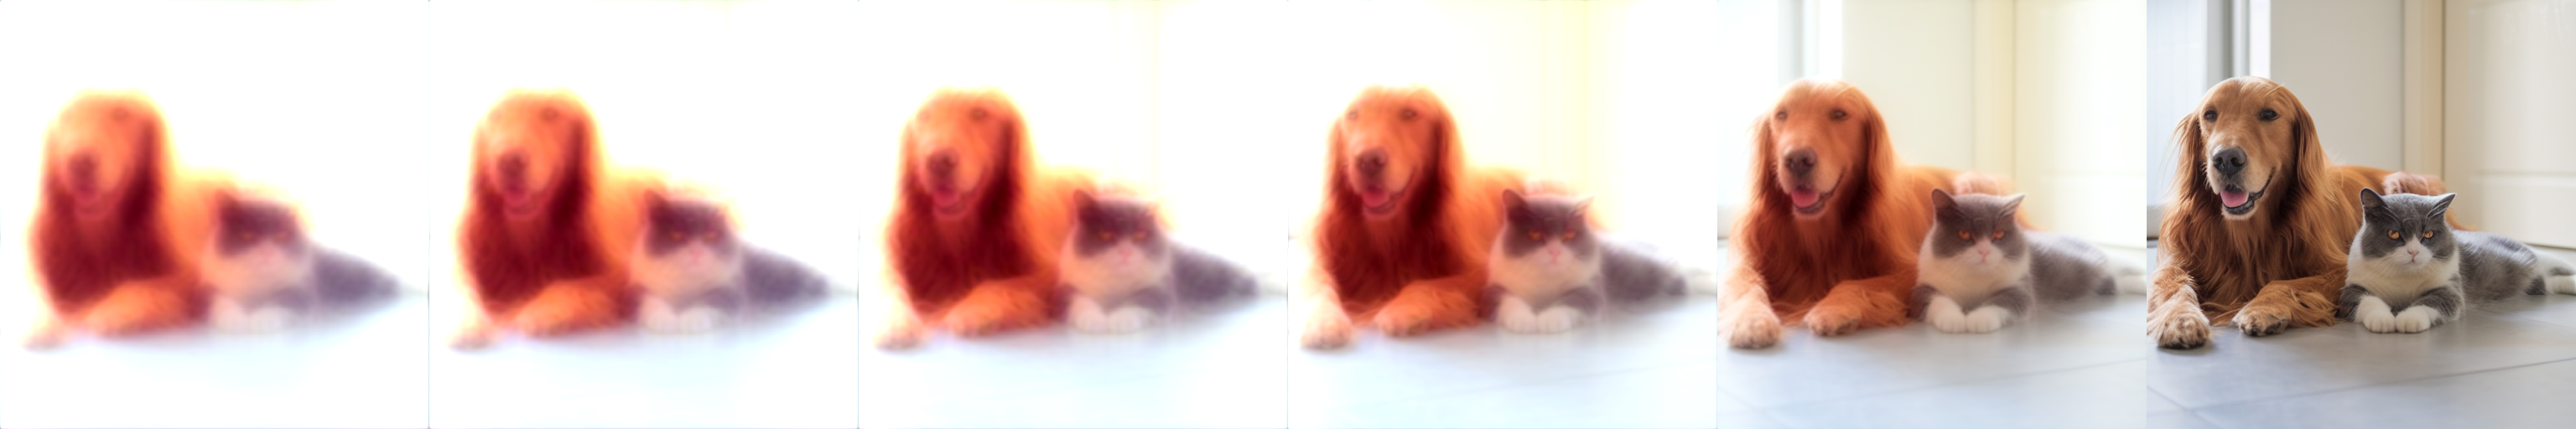

In [134]:
# The images from left to right should be x_50, x_40, x_30, x_20, x_10, x_0.
# We can see that the reconstructed image is very close to the original image.
visualize(image_sampling_list)

Here we use PSNR to evaluate the inverted image quantitatively.

In [135]:
def calculate_psnr(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if mse - 0 < 1e-9:
        print("Same images!")
    else:
        psnr = 20 * np.log10(255.0 / np.sqrt(mse))
        print("PSNR: {}".format(psnr))

In [136]:
# TODO: please run the cell and report the PSNR.
original_image = image_inversion_list[0]
inverted_image = image_sampling_list[-1]

calculate_psnr(np.array(inverted_image), np.array(original_image))

PSNR: 39.319504537310024


## Task 5: Try your own image! (10 pt)

Step 1: Invert your one own image. Follow the same procedure as above and visualize $x_{0}, x_{10}, x_{20}, x_{30}, x_{40}, x_{50}$ from left to right. Please use a prompt that describes your input image. <br>
Step 2: Reconstruct the image from the inverted latent. Follow the same procedure as above and visualize $x_{50}, x_{40}, x_{30}, x_{20}, x_{10}, x_{0}$ from left to right. Please use the same prompt as the inversion prompt.  <br>
Step 3: Compute the PSNR between your original image and the inverted image. <br>
<br>
Please keep all the output in the notebook.

In [ ]:
# TODO